# Example 4 - BPTT vs. RFLO

February 2022

The following notebook works through BPTT in various scenarios and RFLO in various scenarios:
* Training all weights `w_in`,`w_rec` and `w_out`
* Training each set of weights individually

And, specifically for RFLO, training online



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE

from utils.plotting import plot_trained_trajectories

### Train RNN on four targets

In [3]:
from psychrnnEdit.tasks.perceptual_discrimination import PerceptualDiscrimination
from psychrnnEdit.backend.curriculum import Curriculum, default_metric

pds = [PerceptualDiscrimination(dt = 10, tau = 100, T = 200, N_batch = 1, coherence = .7 - i/5) for i in range(4)] # made trial length shorter to match jacob's stuff

metric = default_metric # Function for calculating whether the stage advances and what the metric value is at each metric_epoch. Default: default_metric().
accuracies = [pds[i].accuracy_function for i in range(len(pds))] # optional list of functions to use to calculate network performance for the purposes of advancing tasks. Used by default_metric() to compute accuracy. Default: [tasks[i].accuracy_function for i in range(len(tasks))].
thresholds = [.9 for i in range(len(pds))] # Optional list of thresholds. If metric = default_metric, accuracies must reach the threshold for a given stage in order to advance to the next stage. Default: [.9 for i in range(len(tasks))]
metric_epoch = 1 # calculate the metric / test if advance to the next stage every metric_epoch training epochs.
output_file = None # Optional path to save out metric value and stage to. Default: None.

curriculum = Curriculum(pds, output_file=output_file, metric_epoch=metric_epoch, thresholds=thresholds, accuracies=accuracies, metric=metric)

trial_duration = 20
n_in=4
frac_on = 0.5

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

## Define network hyperparameters

In [4]:
# Set RNN Parameters
params = RNNparams(n_in=2,n_rec=50,n_out=2,tau_rec=100, # made tau matach psychrnntau
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,
               velocity_transform=True, tau_vel = 5, dt_vel = 0.1,
               rng=np.random.RandomState(1))

In [5]:
params.print_params()

n_in: 2
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 100
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 5
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: RandomState(MT19937)


# 1. Training with BPTT

We will see below that BPTT learns faster than RFLO, but both methods are capable of performing the center-out reach task with multiple targets

### 1a: BPTT, All Weights (`W_in`,`W_rec`,`W_out`)

In [5]:

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
bptt = BPTT(net,apply_to=['w_in','w_rec','w_out'],online=False) 


sim.run_session(n_trials=500, curriculum=curriculum, curriculum_test_size = 10, learn_alg=[bptt], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

# fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='BPTT')

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


NameError: name 'curriculum' is not defined

### 1b: BPTT, `W_out` Only

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


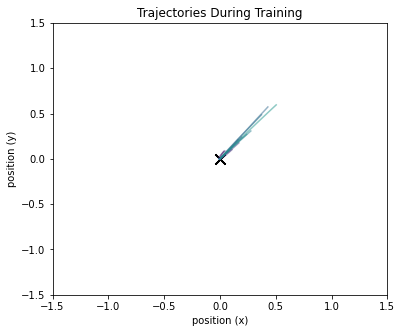

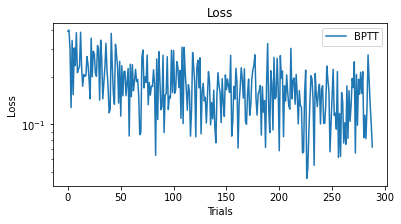

In [12]:

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
bptt = BPTT(net,apply_to=['w_out'],online=False) 


sim.run_session(n_trials=500, curriculum=curriculum, curriculum_test_size = 10, learn_alg=[bptt], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

# fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='BPTT, w_out only') # could run, need to pass in list of already generated tasks though

### 1c: BPTT, `W_rec` only

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180


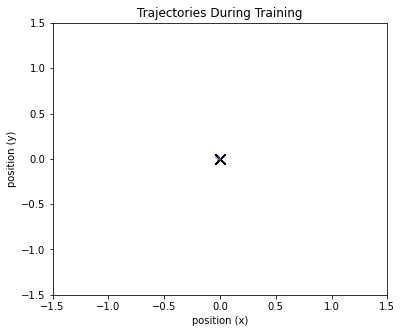

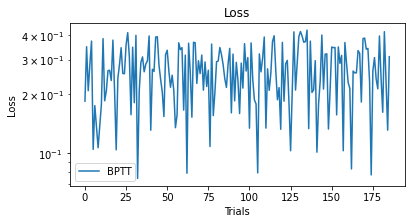

In [17]:

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
bptt = BPTT(net,apply_to=['w_rec'],online=False) 


sim.run_session(n_trials=500,curriculum=curriculum, curriculum_test_size = 10, learn_alg=[bptt], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

# fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='BPTT, w_rec only')

### 1d: BPTT, `W_in` only

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


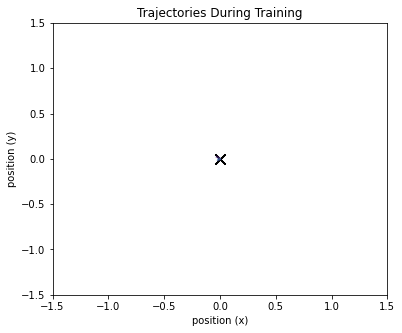

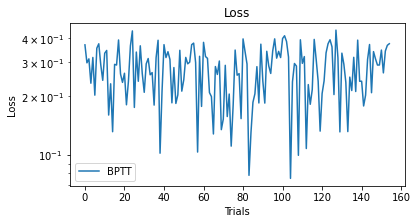

In [20]:

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algsorithm
bptt = BPTT(net,apply_to=['w_in'],online=False) 


sim.run_session(n_trials=500, curriculum=curriculum, curriculum_test_size = 10, learn_alg=[bptt], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

# fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='BPTT, w_in only')

**Comments:** We see that the network performs well with noise when all sets of weights are trained, and pretty well when `w_rec` or `w_out` are trained alone. However, it is more difficult to perform the task when `w_in` is trained alone

In [22]:
curriculum.stage=3

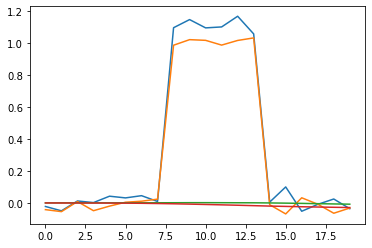

In [33]:
task_tup=x,y,mask, _ = next(curriculum.get_generator_function())
sim.run_trial(task_tup,probe_types=['h','pos', 'loss'],train=True, learn_alg=[bptt])

# plt.plot(sim.probes['loss'])


# plt.plot(mask[0])
# plt.plot(y[0])
plt.plot(x[0])

plt.plot(sim.probes['pos'].squeeze()[:,0])
plt.plot(sim.probes['pos'].squeeze()[:,1])

# 2. Train with RFLO 

### 2a. RFLO, All Weights

apply_to :  ['w_in', 'w_rec', 'w_out']
online :  False
weight_transport :  True
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470


/Users/jasminestone/GitRepos/rnn-learning/psychrnn-testing/../utils/plotting.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick_labels)


480
490


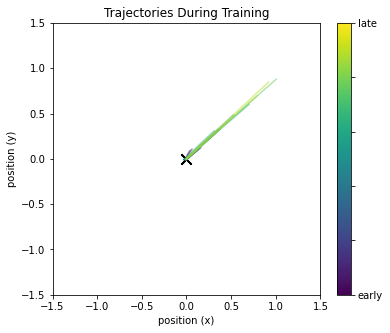

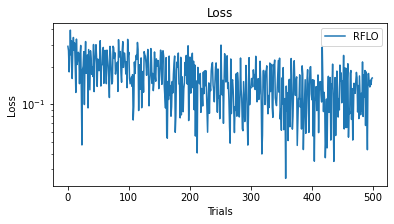

In [6]:
# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_in','w_rec','w_out'],online=False,weight_transport=True) 
rflo.print_params()

sim.run_session(n_trials=500, curriculum=curriculum, curriculum_test_size = 10, learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

# fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='RFLO')


**Comments:** Note here that if we are training `w_out` we want `weight_transport=True` so that `w_m` is updated every time `w_out` is updated.

### 2b. RFLO, `W_rec` only

apply_to :  ['w_rec']
online :  False
weight_transport :  False
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


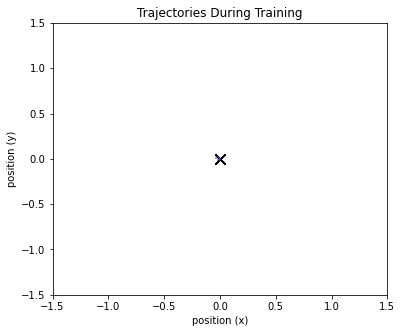

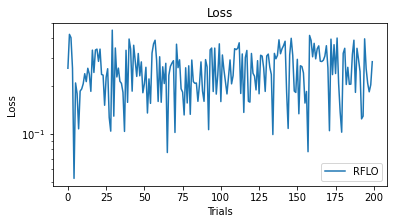

In [9]:
curriculum = Curriculum(pds, output_file=output_file, metric_epoch=metric_epoch, thresholds=thresholds, accuracies=accuracies, metric=metric)

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_rec'],online=False,weight_transport=False) 
rflo.print_params()

sim.run_session(n_trials=1000, curriculum=curriculum, curriculum_test_size = 10, learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

# fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='RFLO, w_rec only')


**Comments:** Note here that if we are **not** training `w_out`, it does not matter whether `weight_transport=True` since `w_m` is initialize with the original (random) `w_out`

### 2c. RFLO, `W_in` only

apply_to :  ['w_in']
online :  False
weight_transport :  False
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570


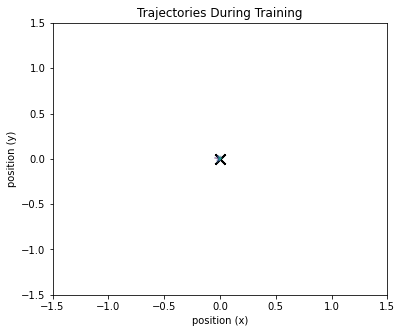

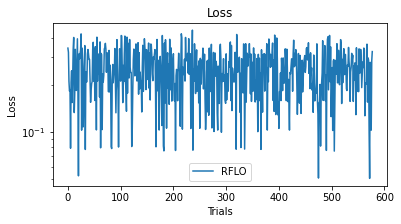

In [10]:
curriculum = Curriculum(pds, output_file=output_file, metric_epoch=metric_epoch, thresholds=thresholds, accuracies=accuracies, metric=metric)

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_in'],online=False,weight_transport=False) 
rflo.print_params()

sim.run_session(n_trials=1000, curriculum=curriculum, curriculum_test_size = 10, learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

# fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='RFLO, w_in only')


### 2d. RFLO, Online learning, `apply_to=['w_rec','w_out']`,`weight_transport=False`

apply_to :  ['w_rec', 'w_out']
online :  True
weight_transport :  False
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320


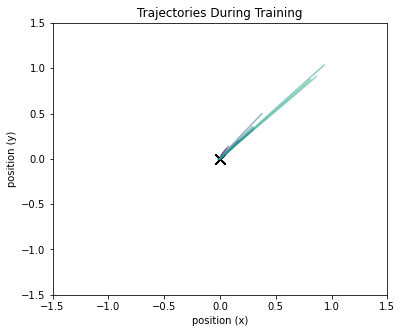

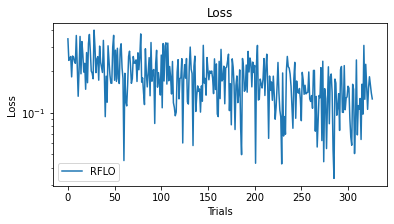

In [12]:
curriculum = Curriculum(pds, output_file=output_file, metric_epoch=metric_epoch, thresholds=thresholds, accuracies=accuracies, metric=metric)
# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_rec','w_out'],online=True,weight_transport=False) 
rflo.print_params()

sim.run_session(n_trials=500, curriculum=curriculum, curriculum_test_size = 10, learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

# fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='RFLO, online, no weight transport')


**Comments:** Presumably this works even though `w_m` is not being set to `w_out`, due to the phenomenon of feedback alignment

### 2e. RFLO, Online learning, `apply_to=['w_rec','w_out']`,`weight_transport=True`

apply_to :  ['w_rec', 'w_out']
online :  True
weight_transport :  True
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250


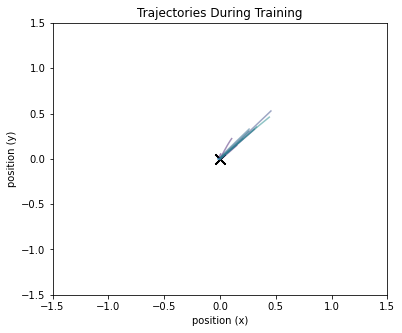

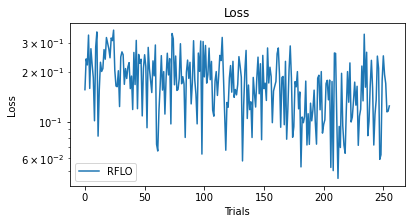

In [13]:
curriculum = Curriculum(pds, output_file=output_file, metric_epoch=metric_epoch, thresholds=thresholds, accuracies=accuracies, metric=metric)
# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_rec','w_out'],online=True,weight_transport=True) 
rflo.print_params()

sim.run_session(n_trials=500, curriculum=curriculum, curriculum_test_size = 10, learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)

# fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='RFLO, online, weight transport')
